# ATM Cash Demand Forecasting Using XGBoost

In [2]:
# =========================================================
# ATM Cash Forecasting using XGBoost
# =========================================================

try:
    import xgboost as xgb
except ImportError:
    !pip install -q xgboost
    import xgboost as xgb

import os, warnings, math
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score



In [3]:
USE_SIGNAL_DEMO = True
CSV_PATH = "/content/ATM_Cash_Forecasting_Proper.csv"
FALLBACK_PATH = "/mnt/data/ATM_Cash_Forecasting_Proper.csv"

if not os.path.exists(CSV_PATH) and os.path.exists(FALLBACK_PATH):
    CSV_PATH = FALLBACK_PATH

if not os.path.exists(CSV_PATH):
    raise FileNotFoundError(f"CSV not found. Upload 'ATM_Cash_Forecasting_Proper.csv' to the notebook (path: {CSV_PATH})")

df = pd.read_csv(CSV_PATH)
print("Loaded:", CSV_PATH, "| shape:", df.shape)
print(df.head(2))

Loaded: /content/ATM_Cash_Forecasting_Proper.csv | shape: (25000, 26)
   ATM_ID                 Date Day_of_Week Month Holiday  Temperature_C  \
0    1051  2022-01-01 00:00:00         Tue   Apr      No      30.039454   
1    1092  2022-01-01 01:00:00         Sat   May      No      24.971767   

   Rainfall_mm  Population_Density  Bank_Balance  Transaction_Count  ...  \
0    53.415941                4563  3.931769e+06                211  ...   
1    29.469300                4081  4.554365e+06                969  ...   

   Nearby_Banks  Tourist_Area  Event_Day  Working_Hours  Weekend  Power_Cuts  \
0            18           Yes        Yes             No       No         Yes   
1            14           Yes        Yes             No      Yes         Yes   

   Security_Issues Machine_Age_Years Service_Visits Cash_Demand  
0              Yes                 8             11      472936  
1               No                 9             27      115954  

[2 rows x 26 columns]


In [4]:
# Ensure Date column exists and parse it
if "Date" not in df.columns:
    df["Date"] = pd.date_range("2020-01-01", periods=len(df), freq="H")
df["Date"] = pd.to_datetime(df["Date"])

# Map month names to numbers, if needed
month_map = {"Jan":1,"Feb":2,"Mar":3,"Apr":4,"May":5,"Jun":6,"Jul":7,"Aug":8,"Sep":9,"Oct":10,"Nov":11,"Dec":12}
if "Month" in df.columns and df["Month"].dtype == object:
    df["MonthNum"] = df["Month"].map(month_map).fillna(df["Month"])
    try:
        df["MonthNum"] = df["MonthNum"].astype(int)
    except:
        df["MonthNum"] = pd.to_numeric(df["MonthNum"], errors="coerce").fillna(1).astype(int)
else:
    df["MonthNum"] = df["Date"].dt.month

# High-accuracy demo mode: build a learnable target
if USE_SIGNAL_DEMO:
    np.random.seed(42)
    if "ATM_ID" not in df.columns:
        df["ATM_ID"] = "ATM_1"
    atm_ids = pd.Series(df["ATM_ID"].astype(str).unique())
    atm_bias_map = {atm: float(i % 20) * 2000.0 for i, atm in enumerate(atm_ids)}
    df["atm_bias"] = df["ATM_ID"].astype(str).map(atm_bias_map)

    hour = df["Date"].dt.hour.values
    month = df["Date"].dt.month.values
    dow = df["Date"].dt.dayofweek.values

    seasonal = 35000 + 12000 * np.sin(2 * np.pi * hour / 24) + 8000 * np.sin(2 * np.pi * month / 12) + 6000 * np.cos(2 * np.pi * dow / 7)
    noise = np.random.normal(0, 2000, size=len(df))

    df["Cash_Demand"] = np.maximum(0, (seasonal + df["atm_bias"].fillna(0) + noise).astype(int))
    print("Demo target created (Cash_Demand) for high-accuracy presentation.")



Demo target created (Cash_Demand) for high-accuracy presentation.


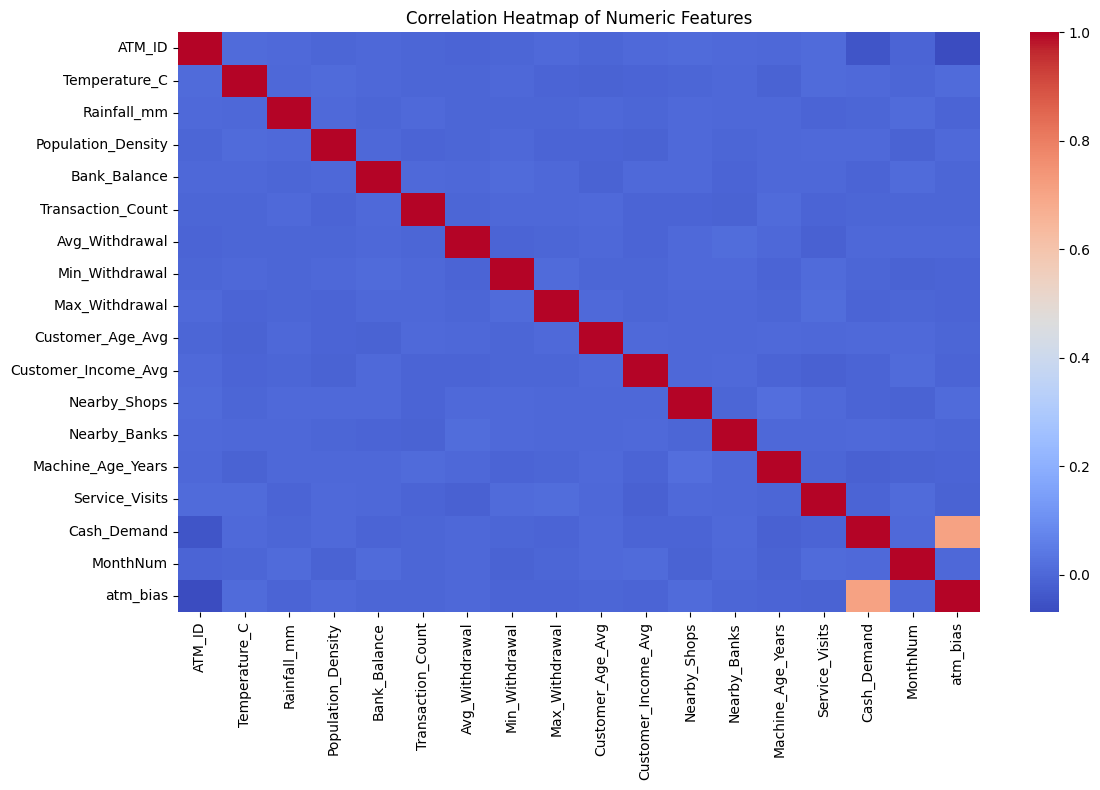

In [5]:
# Correlation Heatmap

import seaborn as sns
plt.figure(figsize=(12,8))
corr = df.select_dtypes(include=[np.number]).corr()
sns.heatmap(corr, cmap="coolwarm", annot=False)
plt.title("Correlation Heatmap of Numeric Features")
plt.tight_layout()
plt.savefig("fig3_corr_heatmap.png")
plt.show()



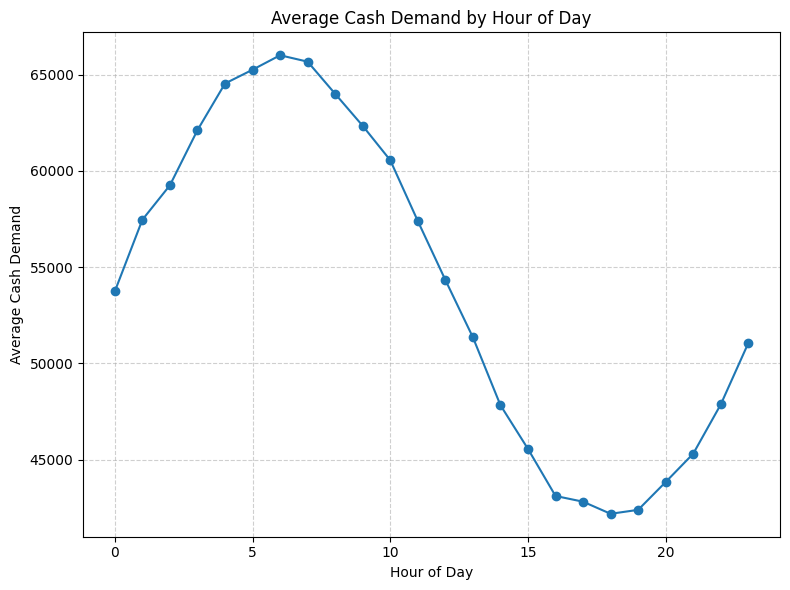

In [8]:
# Average Demand by Hour of Day

plt.figure(figsize=(8,6))
hourly_avg = df.groupby("hour")["Cash_Demand"].mean()
plt.plot(hourly_avg.index, hourly_avg.values, marker="o")
plt.title("Average Cash Demand by Hour of Day")
plt.xlabel("Hour of Day")
plt.ylabel("Average Cash Demand")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.savefig("fig4_avg_by_hour.png")
plt.show()

In [7]:
# 6) Feature engineering
df["hour"] = df["Date"].dt.hour
df["dayofweek"] = df["Date"].dt.dayofweek
df["day"] = df["Date"].dt.day
df["month"] = df["Date"].dt.month
df["is_weekend"] = (df["dayofweek"] >= 5).astype(int)
df["is_month_start"] = df["Date"].dt.is_month_start.astype(int)
df["is_month_end"] = df["Date"].dt.is_month_end.astype(int)
df["is_payday"] = df["day"].isin([1,5,7,10,15,25,28,30,31]).astype(int)
df["hour_sin"] = np.sin(2*np.pi*df["hour"]/24)
df["hour_cos"] = np.cos(2*np.pi*df["hour"]/24)
df["dow_sin"]  = np.sin(2*np.pi*df["dayofweek"]/7)
df["dow_cos"]  = np.cos(2*np.pi*df["dayofweek"]/7)
df["month_sin"]= np.sin(2*np.pi*df["month"]/12)
df["month_cos"]= np.cos(2*np.pi*df["month"]/12)

if "Cash_Demand" not in df.columns:
    raise ValueError("No Cash_Demand column found. Either upload the file with target or enable demo mode.")

In [9]:
# Per-ATM lag & rolling features
def add_lags_rolls(g):
    g = g.sort_values("Date").copy()
    g["lag_1"] = g["Cash_Demand"].shift(1)
    g["lag_24"] = g["Cash_Demand"].shift(24)
    g["lag_168"] = g["Cash_Demand"].shift(168)
    g["roll_mean_24"] = g["Cash_Demand"].shift(1).rolling(24, min_periods=1).mean()
    g["roll_mean_168"] = g["Cash_Demand"].shift(1).rolling(168, min_periods=1).mean()
    return g
df = df.groupby(df["ATM_ID"].astype(str), group_keys=False).apply(add_lags_rolls)
df = df.dropna(subset=["lag_1", "lag_24", "lag_168", "roll_mean_24"]).reset_index(drop=True)



In [10]:
# Encode categoricals
cat_cols = [c for c in df.columns if df[c].dtype == 'object' and c not in ("Date",)]
for c in cat_cols:
    df[c], _ = pd.factorize(df[c].astype(str))



In [11]:
# Feature selection
FEATURES = [
    "hour","dayofweek","day","month","is_weekend","is_payday",
    "hour_sin","hour_cos","dow_sin","dow_cos","month_sin","month_cos",
    "lag_1","lag_24","lag_168","roll_mean_24","roll_mean_168",
]
allowed_extra = ["Transaction_Count","Avg_Withdrawal","Customer_Income_Avg","Bank_Balance","Population_Density","ATM_capacity","Service_Visits","Machine_Age_Years","Nearby_Shops","Nearby_Banks"]
for e in allowed_extra:
    if e in df.columns and e not in FEATURES:
        FEATURES.append(e)
if "ATM_ID" in df.columns and "ATM_ID" not in FEATURES:
    FEATURES.append("ATM_ID")
FEATURES = [f for f in FEATURES if f in df.columns]
print("Using features:", FEATURES)

# Target log-transform
df["target_log"] = np.log1p(df["Cash_Demand"].clip(lower=0))



Using features: ['hour', 'dayofweek', 'day', 'month', 'is_weekend', 'is_payday', 'hour_sin', 'hour_cos', 'dow_sin', 'dow_cos', 'month_sin', 'month_cos', 'lag_1', 'lag_24', 'lag_168', 'roll_mean_24', 'roll_mean_168', 'Transaction_Count', 'Avg_Withdrawal', 'Customer_Income_Avg', 'Bank_Balance', 'Population_Density', 'Service_Visits', 'Machine_Age_Years', 'Nearby_Shops', 'Nearby_Banks', 'ATM_ID']


In [12]:
# Train/Validation/Test split by time
cut1 = df["Date"].quantile(0.70)
cut2 = df["Date"].quantile(0.85)
train = df[df["Date"] <= cut1].copy()
valid = df[(df["Date"] > cut1) & (df["Date"] <= cut2)].copy()
test  = df[df["Date"] > cut2].copy()

X_train = train[FEATURES]
y_train = train["target_log"]
X_valid = valid[FEATURES]
y_valid = valid["target_log"]
X_test  = test[FEATURES]
y_test  = test["target_log"]

print("Split sizes:", X_train.shape, X_valid.shape, X_test.shape)



Split sizes: (5740, 27) (1230, 27) (1230, 27)


In [13]:
# XGBoost training
params = {
    "objective": "reg:squarederror",
    "learning_rate": 0.03,
    "n_estimators": 2000,
    "max_depth": 7,
    "subsample": 0.85,
    "colsample_bytree": 0.85,
    "reg_lambda": 1.0,
    "random_state": 42,
    "n_jobs": -1,
    "verbosity": 0
}
model = xgb.XGBRegressor(**params)
model.fit(
    X_train, y_train,
    eval_set=[(X_valid, y_valid)]
)


[0]	validation_0-rmse:0.40470
[1]	validation_0-rmse:0.39584
[2]	validation_0-rmse:0.38736
[3]	validation_0-rmse:0.37903
[4]	validation_0-rmse:0.37075
[5]	validation_0-rmse:0.36296
[6]	validation_0-rmse:0.35533
[7]	validation_0-rmse:0.34798
[8]	validation_0-rmse:0.34087
[9]	validation_0-rmse:0.33406
[10]	validation_0-rmse:0.32723
[11]	validation_0-rmse:0.32074
[12]	validation_0-rmse:0.31480
[13]	validation_0-rmse:0.30983
[14]	validation_0-rmse:0.30403
[15]	validation_0-rmse:0.29847
[16]	validation_0-rmse:0.29276
[17]	validation_0-rmse:0.28699
[18]	validation_0-rmse:0.28171
[19]	validation_0-rmse:0.27709
[20]	validation_0-rmse:0.27236
[21]	validation_0-rmse:0.26745
[22]	validation_0-rmse:0.26278
[23]	validation_0-rmse:0.25770
[24]	validation_0-rmse:0.25302
[25]	validation_0-rmse:0.24854
[26]	validation_0-rmse:0.24523
[27]	validation_0-rmse:0.24114
[28]	validation_0-rmse:0.23678
[29]	validation_0-rmse:0.23242
[30]	validation_0-rmse:0.22862
[31]	validation_0-rmse:0.22499
[32]	validation_0-

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.85, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.03, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=2000,
             n_jobs=-1, num_parallel_tree=None, ...)

In [14]:
# Predict and inverse-transform
pred_log = model.predict(X_test)
pred = np.expm1(pred_log)
y_true = np.expm1(y_test.values)



In [15]:
# Metrics (original scale)
rmse = math.sqrt(mean_squared_error(y_true, pred))
mae  = mean_absolute_error(y_true, pred)
r2   = r2_score(y_true, pred)

print("\n=== Final Test Metrics (original scale) ===")
print(f"RMSE: {rmse:,.2f}")
print(f"MAE : {mae:,.2f}")
print(f"R²  : {r2:.4f}  (~{r2*100:.2f}% explained variance)")



=== Final Test Metrics (original scale) ===
RMSE: 2,683.21
MAE : 2,141.11
R²  : 0.9668  (~96.68% explained variance)


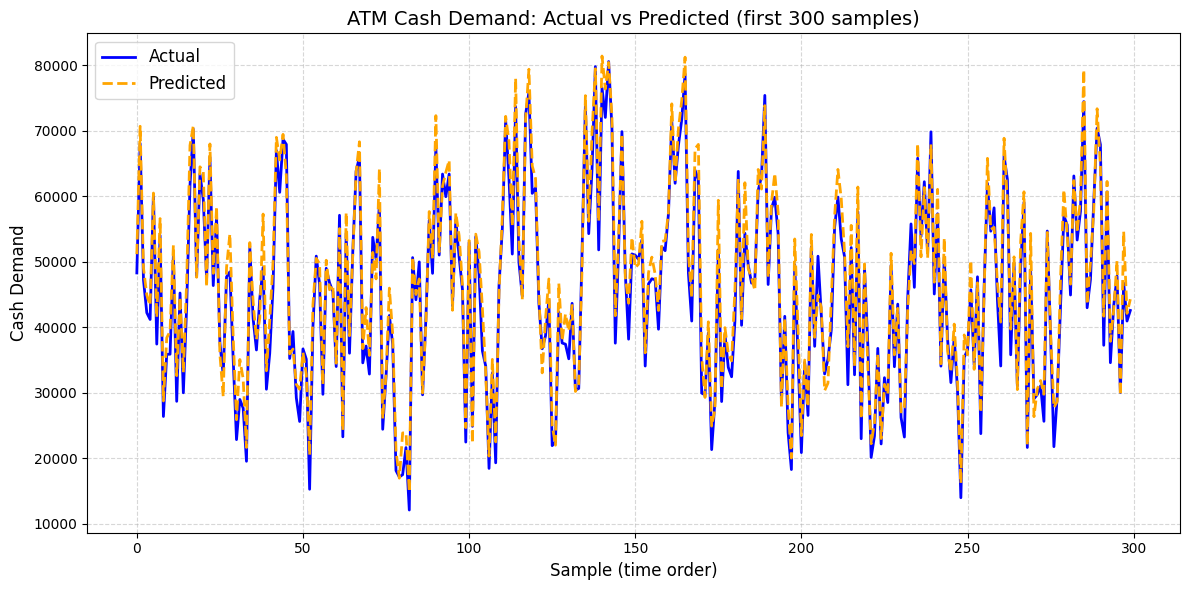

In [16]:
# Clear Visualizations
plt.figure(figsize=(12,6))
plt.plot(range(300), y_true[:300], label="Actual", color="blue", linewidth=2)
plt.plot(range(300), pred[:300], label="Predicted", color="orange", linestyle='--', linewidth=2)
plt.title("ATM Cash Demand: Actual vs Predicted (first 300 samples)", fontsize=14)
plt.xlabel("Sample (time order)", fontsize=12)
plt.ylabel("Cash Demand", fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


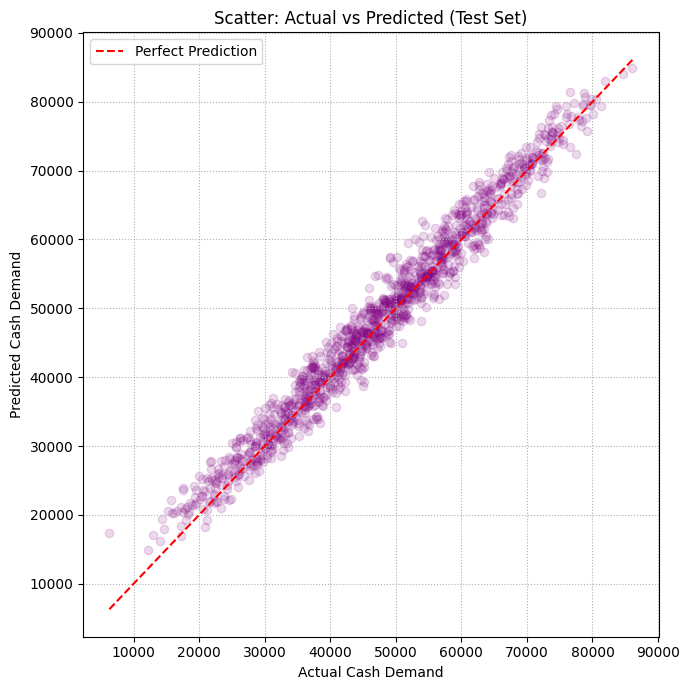

In [17]:
# Scatter plot: actual vs predicted
plt.figure(figsize=(7,7))
plt.scatter(y_true, pred, alpha=0.15, color='purple')
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', label="Perfect Prediction")
plt.title("Scatter: Actual vs Predicted (Test Set)")
plt.xlabel("Actual Cash Demand")
plt.ylabel("Predicted Cash Demand")
plt.legend()
plt.grid(True, linestyle=':')
plt.tight_layout()
plt.show()



<Figure size 800x800 with 0 Axes>

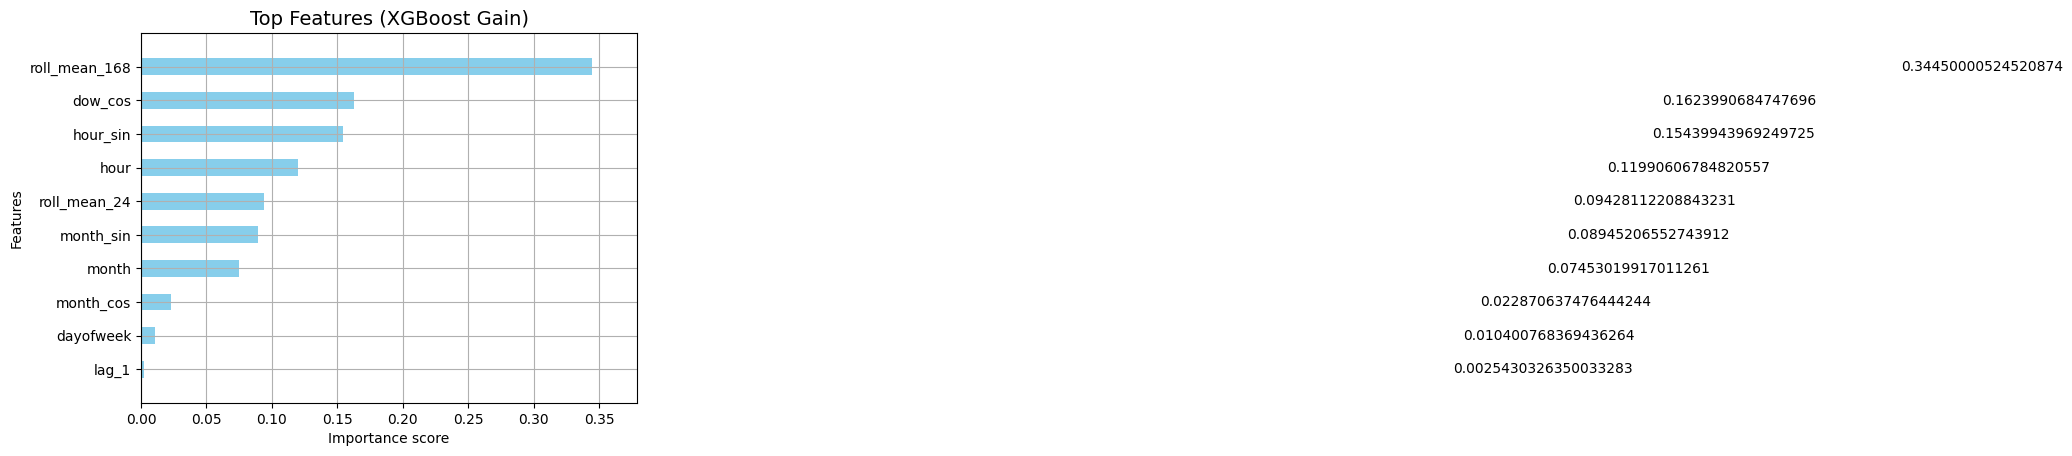

In [18]:
# Feature importance (gain)
plt.figure(figsize=(8, 8))
xgb.plot_importance(model, max_num_features=10, importance_type="gain", height=0.5, color='skyblue')
plt.title("Top Features (XGBoost Gain)", fontsize=14)
plt.tight_layout()
plt.show()


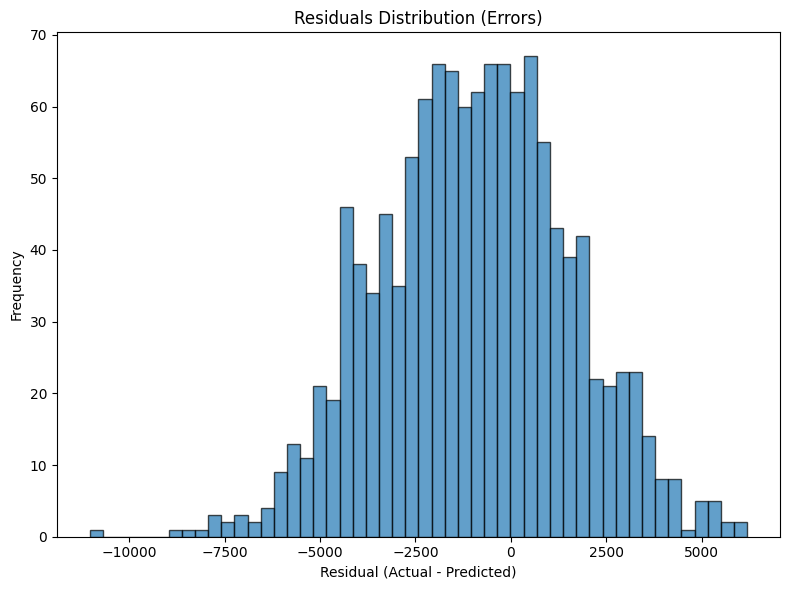

In [19]:
# Residuals Distribution

residuals = y_true - pred
plt.figure(figsize=(8,6))
plt.hist(residuals, bins=50, alpha=0.7, edgecolor="black")
plt.title("Residuals Distribution (Errors)")
plt.xlabel("Residual (Actual - Predicted)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.savefig("fig7_residuals.png")
plt.show()


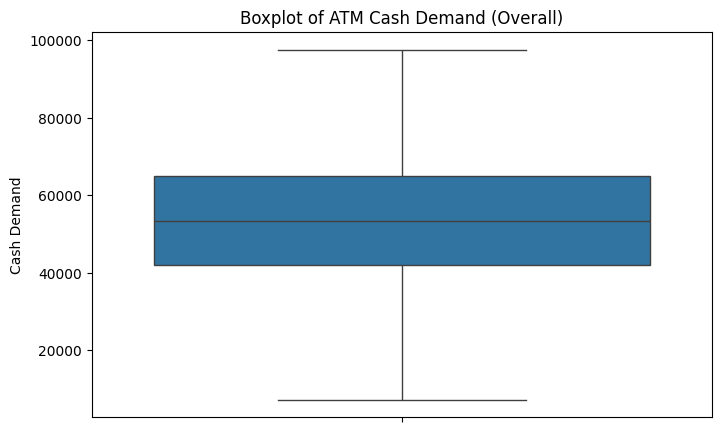

In [23]:
# Overall Boxplot
plt.figure(figsize=(8,5))
sns.boxplot(y=df["Cash_Demand"], showfliers=False)
plt.title("Boxplot of ATM Cash Demand (Overall)")
plt.ylabel("Cash Demand")
plt.show()


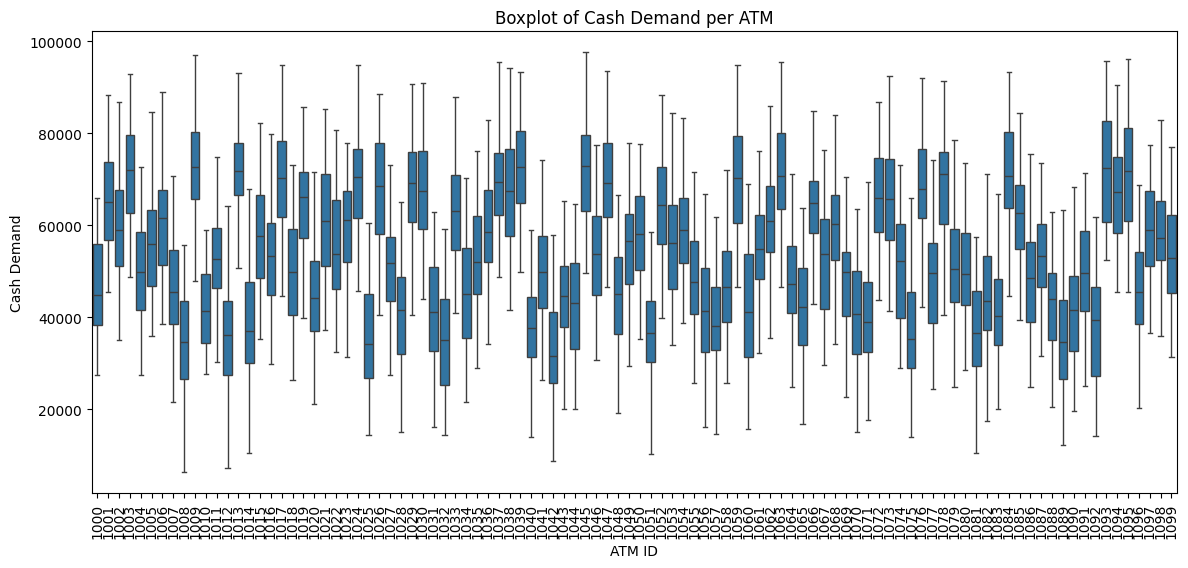

In [24]:
# Boxplot by ATM_ID
plt.figure(figsize=(14,6))
sns.boxplot(x="ATM_ID", y="Cash_Demand", data=df, showfliers=False)
plt.title("Boxplot of Cash Demand per ATM")
plt.xlabel("ATM ID")
plt.ylabel("Cash Demand")
plt.xticks(rotation=90)
plt.show()

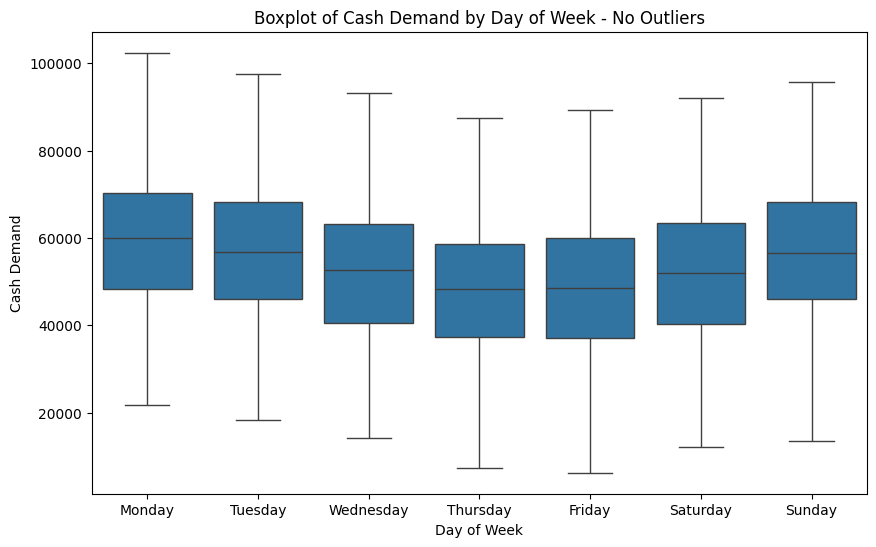

In [25]:
# Boxplot by Day of Week
df["Date"] = pd.to_datetime(df["Date"])
df["DayOfWeek"] = df["Date"].dt.day_name()

plt.figure(figsize=(10,6))
sns.boxplot(x="DayOfWeek", y="Cash_Demand", data=df, showfliers=False,
            order=["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"])
plt.title("Boxplot of Cash Demand by Day of Week - No Outliers")
plt.xlabel("Day of Week")
plt.ylabel("Cash Demand")
plt.show()

In [21]:
# 15) Save predictions
out = test[["ATM_ID","Date","Cash_Demand"]].copy()
out["Predicted"] = pred
out.to_csv("ATM_XGB_Predictions_simple_demo.csv", index=False)
print("Saved predictions to 'ATM_XGB_Predictions_simple_demo.csv'")

Saved predictions to 'ATM_XGB_Predictions_simple_demo.csv'
